# Step 1: Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
from tensorflow.keras.optimizers import RMSprop
import visualkeras
from keras.utils.vis_utils import plot_model
from os import listdir
from os.path import isfile, join



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2: Binary Classification - Masked vs No Mask

## Load and process

In [2]:
# list out the categories that we aim to classify and assign numerical labels
category_lst = ['unmasked', 'correctly_masked']
labels = {0: category_lst[0], 1: category_lst[1]}

# initialize storage for training and test data
full_data = []
train_data = []
test_data = []
y_train = []
y_test = []
i = 0
# directory where data is stored
directory = 'drive/MyDrive/AM 205 Project/'

# loop to load data
for c in category_lst:
  # list all photos in directory belonging to specified class ('unamsked', 'masked', etc.)
  onlyfiles = [f for f in listdir('drive/MyDrive/AM 205 Project/{}'.format(c)) if isfile(join('drive/MyDrive/AM 205 Project/{}'.format(c), f))]
  for o in onlyfiles:
      # upload data and resize for consistency
      img = imread(directory + c + '/' + o)
      img = cv2.resize(img, (100, 140))
      full_data.append(img)
  # randomly shuffle data
  random.shuffle(full_data)
  # select 70% of data for training and 30% for test
  train_data = train_data + full_data[:int(0.7*len(full_data))]
  test_data = test_data +  full_data[int(0.7*len(full_data)):]
  train_length = len(full_data[:int(0.7*len(full_data))])
  test_length = len(full_data[int(0.7*len(full_data)):])
  y_train = y_train + (i*np.ones(train_length)).tolist()
  y_test = y_test + (i*np.ones(test_length)).tolist()
  i = i + 1
  full_data = []






In [ ]:
#convert list to array
train_data = np.array(train_data, dtype = 'int')
test_data = np.array(test_data, dtype = 'int')

In [ ]:
# convert list to array
y_train = np.array(y_train)
y_test = np.array(y_test)

## Define model

In [ ]:
# initialize model architecture
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(140, 100, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')])


In [ ]:
# summarize model
model.summary()

In [ ]:
# compile model with proper loss and accuracy functions
model.compile(loss='binary_crossentropy',
optimizer=RMSprop(lr=0.001),
metrics='accuracy')
tf.config.run_functions_eagerly(True)


## Train Model

In [ ]:
# train model and collect information on trianing 
history = model.fit(train_data, y_train, epochs=50, 
                    validation_data=(test_data, y_test))

## Evaluate model

In [ ]:
# plot train and test accuracy
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.title('Full Masked vs. No Mask: Train versus Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
# get predictions (0 or 1) for classes
pred = model.predict(test_data)
actual = y_test
predicted = []
for p in pred:
  predicted.append(np.round(p[0]))
predicted = np.array(predicted)

In [ ]:
# calculate true positive, true negative, false positive, false negative
TP = tf.math.count_nonzero(predicted * actual)
TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
FP = tf.math.count_nonzero(predicted * (actual - 1))
FN = tf.math.count_nonzero((predicted - 1) * actual)

In [ ]:
# calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
print(precision)
print(recall)
print(f1)

## Check gradients for saliency maps - individual image

In [ ]:
# Load individual images to check gradient
img1 = imread('img1.jpg')
img1 = cv2.resize(img1, (100, 140))
img2 =  imread('img2.JPG')
img2 = cv2.resize(img2, (100, 140))
img3 =  imread('img3.JPG')
img3 = cv2.resize(img3, (100, 140))

In [ ]:
images = tf.Variable(np.array([img1]), dtype=float)
# calculate the gradient with respect to the top class score to see which pixels in the image contribute the most:
with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
grads = tape.gradient(loss, images)
# find max of the absolute values of the gradient along each RGB channel
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
# normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)


In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(img2)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

## Check gradients for saliency maps - average images

In [ ]:
# initialize average array
avg_grad_eval = np.zeros([140,100])

In [ ]:
for i,t in enumerate(test_data):
  # calculate the gradient with respect to the top class score to see which pixels in the image contribute the most:
  images = tf.Variable(np.array([t]), dtype=float)
  with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
  grads = tape.gradient(loss, images)
  # find max of the absolute values of the gradient along each RGB channel
  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
  # normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
  if y_test[i] == 1:
    avg_grad_eval = avg_grad_eval + (1/39)*grad_eval



In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14,5))
i = axes.imshow(avg_grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

# Step 3: Binary Classification - Masked vs Half Masked + No Mask

## Load and process

In [ ]:
# list out the categories that we aim to classify and assign numerical labels
category_lst = ['incorrectly_masked', 'correctly_masked']
labels = {0: category_lst[0], 1: category_lst[1]}

# initialize storage for training and test data
full_data = []
train_data = []
test_data = []
y_train = []
y_test = []
i = 0
# directory where data is stored
directory = 'drive/MyDrive/AM 205 Project/'

# loop to load data
for c in category_lst:
  # list all photos in directory belonging to specified class ('unamsked', 'masked', etc.)
  onlyfiles = [f for f in listdir('drive/MyDrive/AM 205 Project/{}'.format(c)) if isfile(join('drive/MyDrive/AM 205 Project/{}'.format(c), f))]
  for o in onlyfiles:
      # upload data and resize for consistency
      img = imread(directory + c + '/' + o)
      img = cv2.resize(img, (100, 140))
      full_data.append(img)
  # randomly shuffle data
  random.shuffle(full_data)
  # select 70% of data for training and 30% for test
  train_data = train_data + full_data[:int(0.7*len(full_data))]
  test_data = test_data +  full_data[int(0.7*len(full_data)):]
  train_length = len(full_data[:int(0.7*len(full_data))])
  test_length = len(full_data[int(0.7*len(full_data)):])
  y_train = y_train + (i*np.ones(train_length)).tolist()
  y_test = y_test + (i*np.ones(test_length)).tolist()
  i = i + 1
  full_data = []






In [ ]:
#convert list to array
train_data = np.array(train_data, dtype = 'int')
test_data = np.array(test_data, dtype = 'int')

In [ ]:
# convert list to array
y_train = np.array(y_train)
y_test = np.array(y_test)

## Define model

In [ ]:
# initialize model architecture
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(140, 100, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')])


In [ ]:
# summarize model
model.summary()

In [ ]:
# compile model with proper loss and accuracy functions
model.compile(loss='binary_crossentropy',
optimizer=RMSprop(lr=0.001),
metrics='accuracy')
tf.config.run_functions_eagerly(True)


## Train Model

In [ ]:
# train model and collect information on trianing 
history = model.fit(train_data, y_train, epochs=50, 
                    validation_data=(test_data, y_test))

## Evaluate model

In [ ]:
# plot train and test accuracy
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.title('Full Masked vs. No Mask: Train versus Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
# get predictions (0 or 1) for classes
pred = model.predict(test_data)
actual = y_test
predicted = []
for p in pred:
  predicted.append(np.round(p[0]))
predicted = np.array(predicted)

In [ ]:
# calculate true positive, true negative, false positive, false negative
TP = tf.math.count_nonzero(predicted * actual)
TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
FP = tf.math.count_nonzero(predicted * (actual - 1))
FN = tf.math.count_nonzero((predicted - 1) * actual)

In [ ]:
# calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
print(precision)
print(recall)
print(f1)

## Check gradients for saliency maps - individual image

In [ ]:
# Load individual images to check gradient
img1 = imread('img1.jpg')
img1 = cv2.resize(img1, (100, 140))
img2 =  imread('img2.JPG')
img2 = cv2.resize(img2, (100, 140))
img3 =  imread('img3.JPG')
img3 = cv2.resize(img3, (100, 140))

In [ ]:
images = tf.Variable(np.array([img1]), dtype=float)
# calculate the gradient with respect to the top class score to see which pixels in the image contribute the most:
with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
grads = tape.gradient(loss, images)
# find max of the absolute values of the gradient along each RGB channel
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
# normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)


In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(img2)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

## Check gradients for saliency maps - average images

In [ ]:
# initialize average array
avg_grad_eval = np.zeros([140,100])

In [ ]:
for i,t in enumerate(test_data):
  # calculate the gradient with respect to the top class score to see which pixels in the image contribute the most:
  images = tf.Variable(np.array([t]), dtype=float)
  with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
  grads = tape.gradient(loss, images)
  # find max of the absolute values of the gradient along each RGB channel
  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
  # normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
  if y_test[i] == 1:
    avg_grad_eval = avg_grad_eval + (1/39)*grad_eval



In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14,5))
i = axes.imshow(avg_grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

# Step 4: Three Classes

## Load and process

In [ ]:
# list out the categories that we aim to classify and assign numerical labels
category_lst = ['correctly_masked', 'original half masked + javin half masked','unmasked']
labels = {0: category_lst[0], 1: category_lst[1], 2: category_lst[2]}

# initialize storage for training and test data
full_data = []
train_data = []
test_data = []
y_train = []
y_test = []
i = 0
# directory where data is stored
directory = 'drive/MyDrive/AM 205 Project/'

# loop to load data
for c in category_lst:
  # list all photos in directory belonging to specified class ('unamsked', 'masked', etc.)
  onlyfiles = [f for f in listdir('drive/MyDrive/AM 205 Project/{}'.format(c)) if isfile(join('drive/MyDrive/AM 205 Project/{}'.format(c), f))]
  for o in onlyfiles:
      # upload data and resize for consistency
      img = imread(directory + c + '/' + o)
      img = cv2.resize(img, (100, 140))
      full_data.append(img)
  # randomly shuffle data
  random.shuffle(full_data)
  # select 70% of data for training and 30% for test
  train_data = train_data + full_data[:int(0.7*len(full_data))]
  test_data = test_data +  full_data[int(0.7*len(full_data)):]
  train_length = len(full_data[:int(0.7*len(full_data))])
  test_length = len(full_data[int(0.7*len(full_data)):])
  y_train = y_train + (i*np.ones(train_length)).tolist()
  y_test = y_test + (i*np.ones(test_length)).tolist()
  i = i + 1
  full_data = []






In [ ]:
#convert list to array
train_data = np.array(train_data, dtype = 'int')
test_data = np.array(test_data, dtype = 'int')

In [ ]:
# convert list to array
y_train = np.array(y_train)
y_test = np.array(y_test)

## Define model

In [ ]:
# initialize model architecture
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(140, 100, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')])


In [ ]:
# summarize model
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer=RMSprop(lr=0.001),
metrics='accuracy')

In [ ]:
history = model.fit(train_data, y_train, epochs=50, 
                    validation_data=(test_data, y_test))

## Evaluate model

In [ ]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
fig.set_size_inches(18.5, 10.5)
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.title('Full Masked vs. Half-Masked vs No Mask: Train versus Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
pred = model.predict(test_data)


In [ ]:
pred = model.predict(test_data)
actual = y_test
predicted = []
for p in pred:
  predicted.append(np.argmax(p))
predicted = np.array(predicted)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(actual, predicted))

In [ ]:
print(metrics.classification_report(actual, predicted))


## Check gradients for saliency maps - individual image

In [ ]:
# Load individual images to check gradient
img1 = imread('img1.jpg')
img1 = cv2.resize(img1, (100, 140))
img2 =  imread('img2.JPG')
img2 = cv2.resize(img2, (100, 140))
img3 =  imread('img3.JPG')
img3 = cv2.resize(img3, (100, 140))

In [ ]:
images = tf.Variable(np.array([img1]), dtype=float)
# calculate the gradient with respect to the top class score to see which pixels in the image contribute the most:
with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
grads = tape.gradient(loss, images)
# find max of the absolute values of the gradient along each RGB channel
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
# normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)


In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(img2)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

## Check gradients for saliency maps - average images

In [ ]:
# initialize average array
avg_grad_eval = np.zeros([140,100])

In [ ]:
for i,t in enumerate(test_data):
  # calculate the gradient with respect to the top class score to see which pixels in the image contribute the most:
  images = tf.Variable(np.array([t]), dtype=float)
  with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
  grads = tape.gradient(loss, images)
  # find max of the absolute values of the gradient along each RGB channel
  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
  # normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
  if y_test[i] == 1:
    avg_grad_eval = avg_grad_eval + (1/39)*grad_eval



In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14,5))
i = axes.imshow(avg_grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

# Step 5: Visualize Model

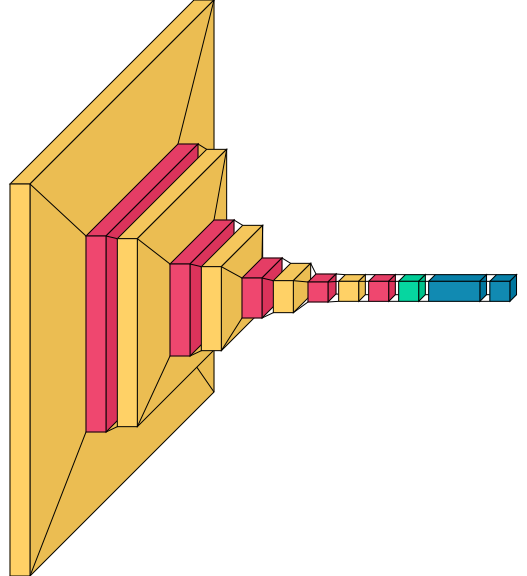

In [ ]:
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

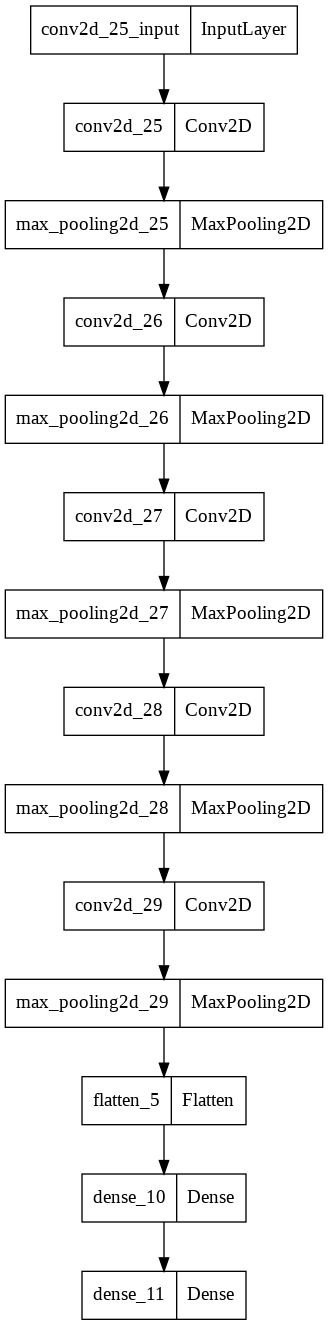

In [ ]:
plot_model(model)